In [1]:
pip install implicit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 20.0 MB/s eta 0:00:00


In [2]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 7.1 MB/s eta 0:00:00


In [3]:
pip install  LightFM

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for LightFM: filename=lightfm-1.17-cp310-cp310-linux_x86_64.whl size=808333 sha256=9b687d4967fe4df583001920867b373f1d2b00e2645e766a7e0d877a7cad4d3a
  Stored in directory: /root/.cache/pip/wheels/4f/9b/7e/0b256f2168511d8fa4dae4fae0200fdbd729eb424a912ad636
Successfully built LightFM


In [1]:
import pandas as pd
import numpy as np
from lightfm.evaluation import precision_at_k
from lightfm.data import Dataset
from lightfm import LightFM
import datetime
import time
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import f1_score, precision_score, recall_score,accuracy_score
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from prometheus_client import start_http_server, Gauge
from   xgboost  import XGBClassifier
from sklearn import metrics

from scipy.sparse import csr_matrix

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules


from scipy.sparse import coo_matrix
import scipy.sparse as sparse
from sklearn import preprocessing

from implicit.als import AlternatingLeastSquares
from implicit.evaluation import mean_average_precision_at_k
import pickle
from lightfm.evaluation import precision_at_k, auc_score

c:\Users\Дмитрий\AppData\Local\Programs\Python\Python39\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [6]:
import pickle
from google.colab import files

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from google.colab import files

In [7]:
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Mounted at /content/drive


In [ ]:
file_path = '/content/drive/MyDrive/diploma/data.pickle'
files.download(file_path)

In [ ]:
import pickle

with open(file_path, 'rb') as f:
    data = pickle.load(f)

In [2]:
import pickle
with open('E:\\DIPLOMA\\data.pickle','rb') as f:
    data = pickle.load(f)
data   

,visitorid,event,itemid,transactionid,data,hour,month,day_of_week,is_weekend,minute,year,is_holiday,time_of_day,property,value,categoryid,parentid
0,257597,view,355908,NaN,2015-06-02 05:02:12.117,5,6,1,0,2,2015,0,Night,NaN,NaN,NaN,NaN
1,992329,view,248676,NaN,2015-06-02 05:50:14.164,5,6,1,0,50,2015,0,Night,NaN,NaN,NaN,NaN
2,111016,view,318965,NaN,2015-06-02 05:13:19.827,5,6,1,0,13,2015,0,Night,NaN,NaN,NaN,NaN
3,483717,view,253185,NaN,2015-06-02 05:12:35.914,5,6,1,0,12,2015,0,Night,NaN,NaN,NaN,NaN
4,951259,view,367447,NaN,2015-06-02 05:02:17.106,5,6,1,0,2,2015,0,Night,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2755636,591435,view,261427,NaN,2015-08-01 03:13:05.939,3,8,5,1,13,2015,0,Night,NaN,NaN,NaN,NaN
2755637,762376,view,115946,NaN,2015-08-01 03:30:13.142,3,8,5,1,30,2015,0,Night,NaN,NaN,NaN,NaN
2755638,1251746,view,78144,NaN,2015-08-01 02:57:00.527,2,8,5,1,57,2015,0,Night,NaN,NaN,NaN,NaN
2755639,1184451,view,283392,NaN,2015-08-01 03:08:50.703,3,8,5,1,8,2015,0,Night,NaN,NaN,NaN,NaN


In [3]:
need_cols =  ['data', 'itemid', 'visitorid', 'event']
df = data[need_cols]

Валидационный датасет
Создадим валидационный датасет, разбив данные по времени. Для этого возьмем последние семь дней данных в качестве валидационного периода.

In [4]:
validation_period = data['data'].max() - pd.DateOffset(days=7)

# Разделим данные на тренировочный и валидационный датасеты
train     = data[df['data'] < validation_period]
test = data[df['data'] >= validation_period]

In [5]:
print(f'train : {train.shape}')
print(f'test: {test.shape}')

train : (2640903, 17)
test: (114738, 17)


# XGBoost


## Для решения задачи классификации добавим в наши данные таргет - 1 при наличии тразакции и 0, если транзакции не было.

In [6]:
train['target'] = train['event'].apply(lambda x: 1 if  x=='transaction' else 0)
test['target'] = test['event'].apply(lambda x: 1 if  x=='transaction' else 0)

In [7]:
cat_features = ['visitorid', 'itemid', 'day_of_week',
       'Month', 'Day', 'Hour', 'minute', 'target']

In [8]:
cat_features

['visitorid',
 'itemid',
 'day_of_week',
 'Month',
 'Day',
 'Hour',
 'minute',
 'target']

In [9]:
# Случайная неполная выборка (нахождение класса большинства и его неполная выборка)
def random_under(df:pd.DataFrame, feature):

    target = df[feature].value_counts()

    if target.values[0]<target.values[1]:
        under = target.index.values[1]

    else:
        under = target.index.values[0]

    df_0 = df[df[feature] != under]
    df_1 = df[df[feature] == under]

    df_treatment_under = df_1.sample(len(df_0))
    df_1 = pd.concat([df_treatment_under, df_0], axis=0)

    return df_1


def create_dataframe(visitor):

    visitor_df_array = []

    for x in visitor:

        #Создание массива, содержащего все данные о посетителе, кроме id
        v_df = data[data.visitorid == x]
        #Создание временного массива для хранения всех атрибутов посетителей
        temp = []
        #Заполнение первого элемента массива текущим индексом
        temp.append(x)
        #Заполнение массива количеством уникальных товаров, просмотренных посетителем (num_uniq_items_viewed)
        temp.append(v_df[v_df.event == 'view'].itemid.unique().size)
        # Заполнение массива количеством просмотров товаров посетителем независимо от того, тот же это продукт или нет (num_views_total)
        temp.append(v_df[v_df.event == 'view'].event.count())
        number_of_items_bought = v_df[v_df.event == 'transaction'].event.count()
        temp.append(number_of_items_bought)

        # если посетитель купил хотя бы 1 товар, атрибуту присваивается значение 1, если посетитель ничего не купил, присваивается значение 0
        if(number_of_items_bought == 0):
            temp.append(0)
        else:
            temp.append(1)

        visitor_df_array.append(temp)

    return pd.DataFrame(visitor_df_array, columns=['visitorid', 'num_uniq_items_viewed', 'num_views_total', 'bought_count', 'purchased'])

In [10]:
train = random_under(train, 'target')

Class 0: 21571
Class 1: 21571
Proportion: 1 : 1


(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

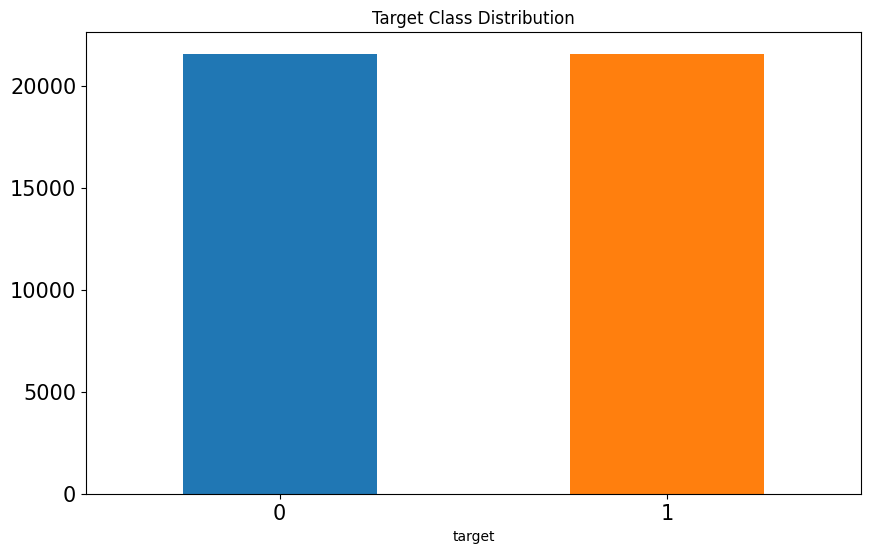

In [11]:
fig = plt.figure(figsize = (10,6))
new_target_count = train['target'].value_counts()
print('Class 0:', new_target_count[0])
print('Class 1:', new_target_count[1])
print('Proportion:', int(round(new_target_count[0] / new_target_count[1])), ': 1')
new_target_count.plot(kind='bar', title='Target Class Distribution', color=['#2077B4', '#FF7F0E'], fontsize = 15)
plt.xticks(rotation=0)

In [12]:
X_train = train[['visitorid', 'itemid', 'day_of_week','month', 'hour']]
X_test = test[['visitorid', 'itemid', 'day_of_week','month', 'hour']]
y_train = train['target']
y_test = test['target']

In [13]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [14]:
preds = xgb.predict(X_test)

In [15]:
print('precision_score = {:7.4f}'.format(metrics.precision_score(y_test, preds)))
print('recall_score = {:7.4f}'.format(metrics.recall_score(y_test, preds)))
print('f1_score = {:7.4f}'.format(metrics.f1_score(y_test, preds)))
print('accuracy = {:7.4f}'.format(metrics.accuracy_score(y_test, preds)))

precision_score =  0.0122
recall_score =  0.4831
f1_score =  0.0238
accuracy =  0.6942


# CatBoostClassifier - это реализация алгоритма градиентного бустинга над решающими деревьями для задач классификации в библиотеке CatBoost.

In [16]:
from catboost import CatBoostClassifier

In [ ]:
cb = CatBoostClassifier()

# Обучение модели
cb.fit(X_train, y_train)

In [18]:
pred = cb.predict(X_test)

In [19]:

print('precision_score = {:7.4f}'.format(metrics.precision_score(y_test, pred)))
print('recall_score = {:7.4f}'.format(metrics.recall_score(y_test, pred)))
print('f1_score = {:7.4f}'.format(metrics.f1_score(y_test, preds)))
print('accuracy = {:7.4f}'.format(metrics.accuracy_score(y_test, pred)))

precision_score =  0.0132
recall_score =  0.4334
f1_score =  0.0238
accuracy =  0.7459


# Коллаборативная фильтрация

###  список всех идентификаторов клиентов.

In [20]:
all_visitors = data.visitorid.sort_values().unique()
all_visitors.size

1407580

###  список клиентов, которые что-то купили.

In [21]:
buy_visitors = data[data.event == 'transaction'].visitorid.sort_values().unique()
buy_visitors.size

11719

In [22]:
view_visitors = list([x for x in all_visitors if x not in buy_visitors])

In [23]:
buy_visitors_df = create_dataframe(buy_visitors)

In [24]:
buy_visitors_df.head(3)

,visitorid,num_uniq_items_viewed,num_views_total,bought_count,purchased
0,172,22,33,2,1
1,186,1,2,1,1
2,264,2,3,2,1


In [25]:
trainCF = data[pd.to_datetime(data['data'], unit='ms') < pd.Timestamp('2015-08-15 00:00:00.000000')]
testCF = data[pd.to_datetime(data['data'], unit='ms') >= pd.Timestamp('2015-08-15 00:00:00.000000')]

### список, который содержит заказы клиентов и элементы внутри них.

In [27]:
purchased_items = []

for customer in buy_visitors:
    purchased_items.append(list(data.loc[(data.visitorid == customer) & (data.transactionid.notnull())].itemid.values))

 ### функция, которая выдавала бы список товаров, которые были куплены вместе с указанным товаром.

In [29]:
def recommender_bought_bought(item_id, purchased_items):

    # Perhaps implement a binary search for that item id in the list of arrays
    # Then put the arrays containing that item id in a new list
    # Then merge all items in that list and get rid of duplicates
    recommender_list = []
    for x in purchased_items:
        if item_id in x:
            recommender_list += x

    #Then merge recommender list and remove the item id
    recommender_list = list(set(recommender_list) - set([item_id]))

    return recommender_list

###  функцию расчета метрики.

In [30]:
def metrik_p3(df):
  res = len(set(top3) & set(df))
  p_3= round((res/3),2)
  return p_3

 ###  введем идентификатор элемента, получим список элементов, которые появились в заказах с указанным элементом.

In [31]:
recommender_bought_bought(302422, purchased_items)[:3]

[105792, 200793, 12836]

 список ТОП-3 товаров.

In [32]:
top3 = list(train.itemid.value_counts()[:3].index)
top3

[461686, 119736, 213834]

 ## метрика на 30 произвольных записи из тестовой части.

In [33]:
test_sample = testCF[testCF['event']=='transaction'].sample(n=30)

In [34]:
test_sample.head(3)

,visitorid,event,itemid,transactionid,data,hour,month,day_of_week,is_weekend,minute,year,is_holiday,time_of_day,property,value,categoryid,parentid
1215329,1126569,transaction,416017,17406.0,2015-09-03 20:56:08.416,20,9,3,0,56,2015,0,Evening,NaN,NaN,NaN,NaN
1040054,339526,transaction,422709,16713.0,2015-08-26 03:38:13.335,3,8,2,0,38,2015,0,Night,NaN,NaN,NaN,NaN
1403229,1344604,transaction,161102,1971.0,2015-09-14 03:44:44.182,3,9,0,0,44,2015,0,Night,NaN,NaN,NaN,NaN


In [35]:
test_sample['1'] = test_sample['itemid'].apply(lambda row: recommender_bought_bought(row, purchased_items)[0:1])
test_sample['2'] = test_sample['itemid'].apply(lambda row: recommender_bought_bought(row, purchased_items)[1:2])
test_sample['3'] =test_sample['itemid'].apply(lambda row: recommender_bought_bought(row, purchased_items)[2:3])

In [36]:
def replace_col(df):
  df =  df.apply(lambda x: str(x).replace('[', ''))
  df =  df.apply(lambda x: str(x).replace(']', ''))
  return df

In [37]:
test_sample['1'] =  replace_col(test_sample['1'])
test_sample['2'] =  replace_col(test_sample['2'])
test_sample['3'] =  replace_col(test_sample['3'])
test_sample['1'] = test_sample['1'].apply(lambda x: top3[0] if x=='' else x)
test_sample['2'] = test_sample['2'].apply(lambda x: top3[1] if x=='' else x)
test_sample['3'] = test_sample['3'].apply(lambda x: top3[2] if x=='' else x)

In [38]:
test_sample['pred'] = test_sample[['1', '2', '3']].values.tolist()

In [39]:
test_sample['p@3'] = 0

In [40]:
index = test_sample.pred.index
for i in index:
  test_sample['p@3'][i] = metrik_p3(test_sample['pred'][i])

In [41]:
test_sample.head(3)

,visitorid,event,itemid,transactionid,data,hour,month,day_of_week,is_weekend,minute,...,time_of_day,property,value,categoryid,parentid,1,2,3,pred,p@3
1215329,1126569,transaction,416017,17406.0,2015-09-03 20:56:08.416,20,9,3,0,56,...,Evening,NaN,NaN,NaN,NaN,307201,376834,259078,"[307201, 376834, 259078]",0.00
1040054,339526,transaction,422709,16713.0,2015-08-26 03:38:13.335,3,8,2,0,38,...,Night,NaN,NaN,NaN,NaN,360673,66146,357859,"[360673, 66146, 357859]",0.00
1403229,1344604,transaction,161102,1971.0,2015-09-14 03:44:44.182,3,9,0,0,44,...,Night,NaN,NaN,NaN,NaN,437827,119736,213834,"[437827, 119736, 213834]",0.67


In [43]:
# Precision@3
metric = round(test_sample['p@3'].mean(),2)
print('Mean Average Precision at 3: {:.2}'.format(metric))

Mean Average Precision at 3: 0.21


# ALS

In [41]:
dfALS = data.copy()

In [42]:
dfALS['event_scores'] = dfALS['event'].apply(
    lambda x: 1 if x == 'view' else 5 if x == 'addtocart' else 25 if x == 'transaction' else 0
)

In [43]:
dfALS.head(3)

,visitorid,event,itemid,transactionid,data,hour,month,day_of_week,is_weekend,minute,year,is_holiday,time_of_day,property,value,categoryid,parentid,event_scores
0,257597,view,355908,NaN,2015-06-02 05:02:12.117,5,6,1,0,2,2015,0,Night,NaN,NaN,NaN,NaN,1
1,992329,view,248676,NaN,2015-06-02 05:50:14.164,5,6,1,0,50,2015,0,Night,NaN,NaN,NaN,NaN,1
2,111016,view,318965,NaN,2015-06-02 05:13:19.827,5,6,1,0,13,2015,0,Night,NaN,NaN,NaN,NaN,1


 ###  преобразуем стобцы их в разреженную матрицу для экономии места и чтобы наша модель была способна вычислять все возможные взаимодействия в наборе данных. По  модулю scipy.sparse.

In [44]:
dfALS['visitorid'] = dfALS['visitorid'].astype("category").cat.as_ordered()
dfALS['itemid'] = dfALS['itemid'].astype("category").cat.as_ordered()

sparse_item_user = sparse.csr_matrix((dfALS['event_scores'].astype(float), (dfALS['itemid'], dfALS['visitorid'])))
sparse_user_item = sparse.csr_matrix((dfALS['event_scores'].astype(float), (dfALS['visitorid'], dfALS['itemid'])))

In [45]:
trainALS = dfALS[pd.to_datetime(dfALS['data'], unit='ms') < pd.Timestamp('2015-08-15 00:00:00.000000')]
testALS = dfALS[pd.to_datetime(dfALS['data'], unit='ms') >= pd.Timestamp('2015-08-15 00:00:00.000000')]

In [46]:
trainALS['visitorid'] = trainALS['visitorid'].astype("category").cat.as_ordered()
trainALS['itemid'] = trainALS['itemid'].astype("category").cat.as_ordered()

testALS['visitorid'] = testALS['visitorid'].astype("category").cat.as_ordered()
testALS['itemid'] = testALS['itemid'].astype("category").cat.as_ordered()

In [47]:
sparse_train_item_user = sparse.csr_matrix((trainALS['event_scores'].astype(float), (trainALS['itemid'], trainALS['visitorid'])))
sparse_train_user_item = sparse.csr_matrix((trainALS['event_scores'].astype(float), (trainALS['visitorid'], trainALS['itemid'])))

In [48]:
sparse_test_item_user = sparse.csr_matrix((testALS['event_scores'].astype(float), (testALS['itemid'], testALS['visitorid'])))
sparse_test_user_item = sparse.csr_matrix((testALS['event_scores'].astype(float), (testALS['visitorid'], testALS['itemid'])))

 ### матрицы готовы, мы можем параметризовать и подогнать нашу модель.

#### Используемые параметры являются довольно стандартными: латентные_факторы и n_iter параметры, которые изменяются чаще, поскольку их увеличение увеличило бы прогностическую силу нашей модели за счет более высоких вычислений, использования памяти и вероятности переобучения для нашей оценки.

In [49]:
latent_factors = 20
regularization = 0.1
n_iter = 20
alpha = 40

conf_matrix = (sparse_train_item_user * alpha).astype('double')

model = AlternatingLeastSquares(
    factors=latent_factors,
    regularization=regularization,
    iterations=n_iter
)

model.fit(conf_matrix)

100%|██████████| 20/20 [05:55<00:00, 17.78s/it]


In [50]:
p_at3_als = mean_average_precision_at_k(model, sparse_train_item_user, sparse_test_item_user, K=3)
print('Mean Average Precision at 3: {:.2%}'.format(p_at3_als))

100%|██████████| 119873/119873 [11:36<00:00, 172.09it/s]

Mean Average Precision at 3: 0.13%


In [51]:
def recommend_item_to_user(model, visitorid, sparse_test_item_user, n=3):
    recommended = model.recommend(visitorid, sparse_test_item_user[visitorid], n)
    return recommended


def similar_items_to_item(model, itemid, n=3):
    similar = model.similar_items(itemid, n)
    return similar

In [55]:
userid =66666
recommended_items = recommend_item_to_user(model, userid, sparse_test_item_user)
print(f"Recommended items for user {userid}:\n{recommended_items[0]}")

Recommended items for user 66666:
[ 899857 1385073  530559]


In [56]:
itemid =4560
similar_items = similar_items_to_item(model, itemid)
print(f"Similar items to {itemid}:\n{similar_items[0]}")

Similar items to 4560:
[   4560   90192 1147502]


# LightFM
## LightFM — это реализация на Python ряда популярных алгоритмов рекомендаций как для неявной, так и для явной обратной связи.

In [66]:
from lightfm.evaluation import precision_at_k
from lightfm.data import Dataset

In [65]:

from lightfm.evaluation import precision_at_k
from lightfm.data import Dataset


trainLFM = data[pd.to_datetime(data['data'], unit='ms') < pd.Timestamp('2015-08-15 00:00:00.000000')]
testLFM = data[pd.to_datetime(data['data'], unit='ms') >= pd.Timestamp('2015-08-15 00:00:00.000000')]

In [67]:
validation_period = data['data'].max() - pd.DateOffset(days=7)

# Разделим данные на тренировочный и валидационный датасеты
train     = data[data['data'] < validation_period]
test = data[data['data'] >= validation_period]

In [68]:

all_visitorids = data.visitorid.unique()
all_itemids = data.itemid.unique()


In [69]:

dataset = Dataset()

In [70]:
dataset.fit(users=all_visitorids, items=all_itemids)

In [71]:

train_coo = dataset.build_interactions(trainLFM.query('event =="transaction"')[['visitorid', 'itemid']].values)

In [72]:

test_coo = dataset.build_interactions(testLFM.query('event =="transaction"')[['visitorid', 'itemid']].values)

In [71]:
modelLFM = LightFM(loss='warp', no_components=50, random_state=42)
modelLFM.fit(train_coo[0], epochs=20)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [72]:
p_at3 = precision_at_k(modelLFM, test_coo[0], k=3).mean()
print('Mean Average Precision at 3: {:.2%}'.format(p_at3))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Mean Average Precision at 3: 0.76%


In [73]:
import numpy as np
scores = modelLFM.predict(1, np.arange(len(all_itemids)))
top = np.argsort(-scores)[:3]
item_lagels = {v:k for k, v in dataset.mapping()[2].items()}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [74]:
[item_lagels[k] for k in top]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[461686, 7943, 416017]

In [75]:
#количество пользователей и товаров в обучающих данных
df = data[['itemid']]
items = df.to_numpy()

def sample_recommendation(model, data, user_ids):

    n_users, n_items = data.shape

    #generate recommendations for each user we input
    for user_id in user_ids:

        #movies our model predicts they will like
        scores = model.predict(user_id, np.arange(n_items))

        #rank them in order of most liked to least
        top_items = items[np.argsort(-scores)][:3]

        print(top_items)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [76]:
sample_recommendation(modelLFM, test_coo[0], [7])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[286057]
 [224900]
 [369638]]


In [77]:
n_users, n_items = test_coo[0].shape

for user_id in [1]:
    scores = modelLFM.predict(user_id, np.arange(n_items))
    top_items = items[np.argsort(-scores)][:3]
    print(top_items)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[286057]
 [224900]
 [369638]]


In [78]:
sample_recommendation(modelLFM, test_coo[1], [6])

[[286057]
 [224900]
 [369638]]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [79]:
def get_recommendations(model, data, user_id, num_recs=3):
    n_items = data['itemid'].nunique()
    user_ids = np.array([user_id] * n_items)
    item_ids = np.arange(n_items)

    scores = model.predict(user_ids, item_ids)
    top_item_indices = np.argsort(-scores)[:num_recs]
    top_items = data['itemid'].values[top_item_indices]

    return top_items

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [80]:
user_id = 46666
top_recommendations = get_recommendations(modelLFM, data, user_id)
print(f"Рекомендуемые товары для пользователя {user_id}: {top_recommendations}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Рекомендуемые товары для пользователя 46666: [286057 224900 453219]


# Сохранение

In [81]:
# Подключение Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Сохранение модели LightFM в корневой директории Google Drive
import pickle

with open('/content/drive/MyDrive/diploma/lightfm_model.pickle', 'wb') as f:
    pickle.dump(modelLFM, f, protocol=pickle.HIGHEST_PROTOCOL)

print('Модель успешно сохранена в Google Drive')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Модель успешно сохранена в Google Drive


In [82]:
# Подключение Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Сохранение модели LightFM в корневой директории Google Drive
import pickle

with open('/content/drive/MyDrive/diploma/lightfm_data_mapping.pickle', 'wb') as f:
    pickle.dump(modelLFM, f, protocol=pickle.HIGHEST_PROTOCOL)

print('Модель успешно сохранена в Google Drive')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Модель успешно сохранена в Google Drive


Чтобы сохранить файл lightfm_model.pickle на локальный диск вашего компьютера, вы можете использовать следующий код:

In [83]:
with open('lightfm_model.pickle', 'wb') as f:
    pickle.dump(modelLFM, f, protocol=pickle.HIGHEST_PROTOCOL)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [84]:
visitors_items_mapping = dataset.mapping()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [85]:
with open('lightfm_data_mapping.pickle', 'wb') as f:
    pickle.dump(visitors_items_mapping , f, protocol=pickle.HIGHEST_PROTOCOL)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# чтение

In [58]:
with open('lightfm_data_mapping.pickle', 'rb') as f:
    loaded_model1 = pickle.load(f)

In [59]:
loaded_model1

({257597: 0,
  992329: 1,
  111016: 2,
  483717: 3,
  951259: 4,
  972639: 5,
  810725: 6,
  794181: 7,
  824915: 8,
  339335: 9,
  176446: 10,
  929206: 11,
  15795: 12,
  598426: 13,
  223343: 14,
  57036: 15,
  1377281: 16,
  287857: 17,
  1370216: 18,
  158090: 19,
  1398644: 20,
  653756: 21,
  1213673: 22,
  864246: 23,
  125625: 24,
  608100: 25,
  781127: 26,
  1076270: 27,
  453474: 28,
  1153198: 29,
  273888: 30,
  849453: 31,
  487887: 32,
  629333: 33,
  1130165: 34,
  361387: 35,
  112175: 36,
  860082: 37,
  784669: 38,
  1061147: 39,
  485456: 40,
  1342963: 41,
  969887: 42,
  759369: 43,
  1282360: 44,
  233317: 45,
  392042: 46,
  591038: 47,
  692195: 48,
  432882: 49,
  808133: 50,
  180680: 51,
  1151716: 52,
  597724: 53,
  179437: 54,
  794013: 55,
  975530: 56,
  741702: 57,
  1219180: 58,
  1143908: 59,
  1078178: 60,
  503970: 61,
  1193904: 62,
  376913: 63,
  1262470: 64,
  238317: 65,
  800456: 66,
  1219627: 67,
  526166: 68,
  685949: 69,
  721839: 70,
 

In [60]:
with open('lightfm_model.pickle', 'rb') as f:
    loaded_model = pickle.load(f)

In [61]:
loaded_model

In [ ]:
import numpy as np

# Получаем размеры взаимодействий пользователей с элементами
n_users, n_items = test_coo[0].shape

# Укажите user_id, для которого нужно получить рекомендации
user_id = 44 # Замените на нужный user_id

# Получаем рекомендации для указанного user_id
scores = modelLFM.predict(user_id, np.arange(n_items))
top_items = items[np.argsort(-scores)][:3]
print(f"Рекомендации для user_id {user_id}:")
print(top_items)

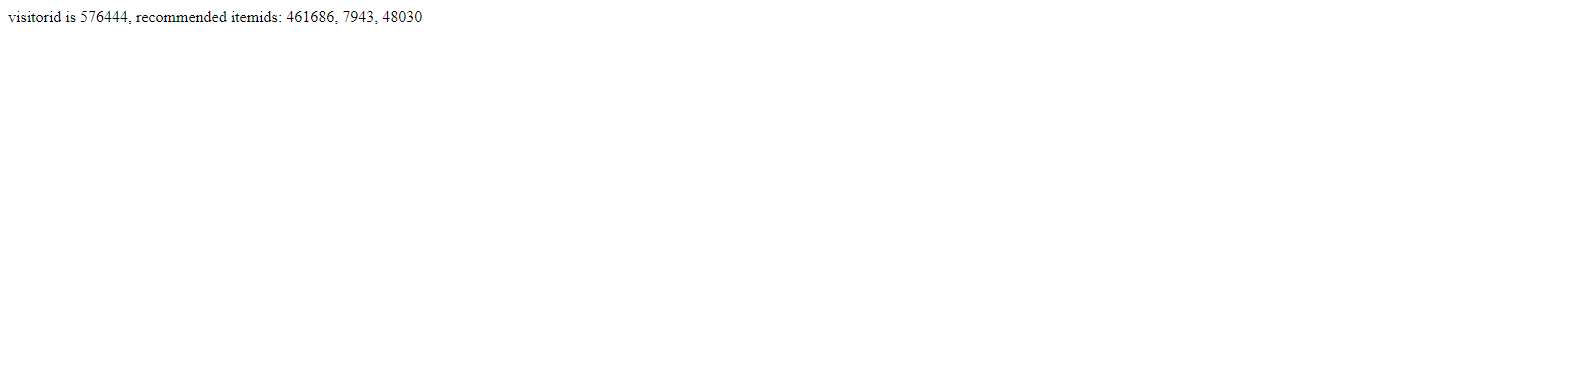

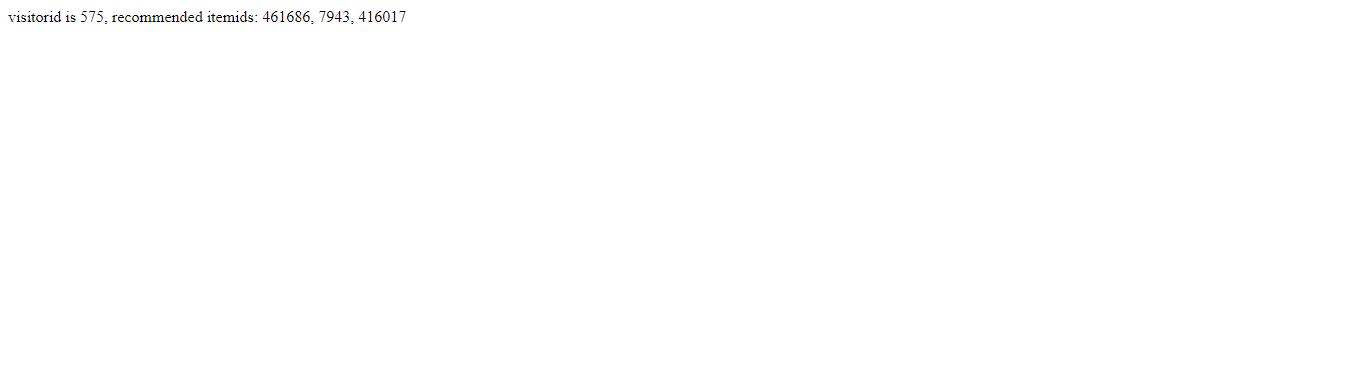

## Метрики переданные  в Prometheus    после обучения  CatBoostClassifier

In [33]:
if __name__ == '__main__':
    start_http_server(9182)

In [35]:
print('precision_score = {:7.4f}'.format(metrics.precision_score(y_test, pred)))
print('recall_score = {:7.4f}'.format(metrics.recall_score(y_test, pred)))
print('f1_score = {:7.4f}'.format(metrics.f1_score(y_test, preds)))
print('accuracy = {:7.4f}'.format(metrics.accuracy_score(y_test, pred)))

precision_score =  0.0132
recall_score =  0.4334
f1_score =  0.0238
accuracy =  0.7459


In [30]:
y_pred = cb.predict(X_test)
pred_classes = np.where(y_pred > 0.5, 1, 0)

In [34]:
# Создание объектов Gauge для метрик
g_precision = Gauge('model_precision', 'Precision of the model')
g_recall = Gauge('model_recall', 'Recall of the model')
g_f1 = Gauge('model_f1_score', 'F1-score of the model')
g_accuracy = Gauge('model_accuracy_score', 'accuracy_score of the model')


# Зафиксируем полученные значения метрик модели в метрики для передачи в Prometheus
g_precision.set(precision_score(y_test, pred_classes))
g_recall.set(recall_score(y_test, pred_classes))
g_f1.set(f1_score(y_test, pred_classes))
g_accuracy.set(accuracy_score(y_test, pred_classes))